In [36]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import arch as arch

ModuleNotFoundError: No module named 'arch'

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [37]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [38]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

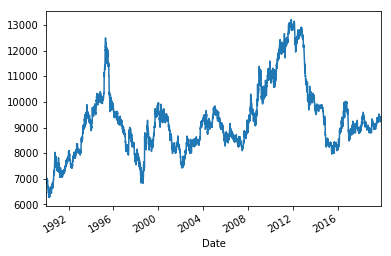

In [39]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!
yen_futures.Settle.plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [40]:
import statsmodels.api as sm
#from statsmodels.tsa.stattools import adfuller

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

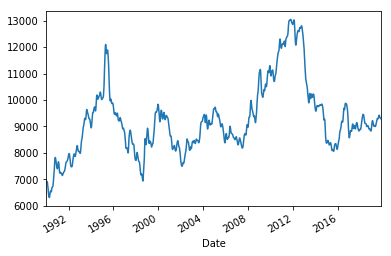

In [17]:
ts_trend.plot()

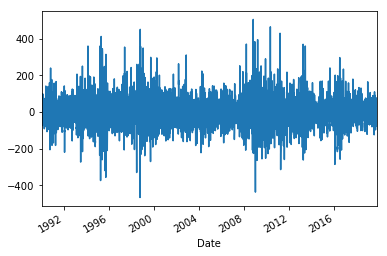

In [9]:
ts_noise.plot()

In [10]:
yen_futures['ts_noise'] = ts_noise

In [11]:
yen_futures['ts_trend'] = ts_trend

In [119]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
yen_futures[['Settle','ts_noise','ts_trend']].head()

,Settle,ts_noise,ts_trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


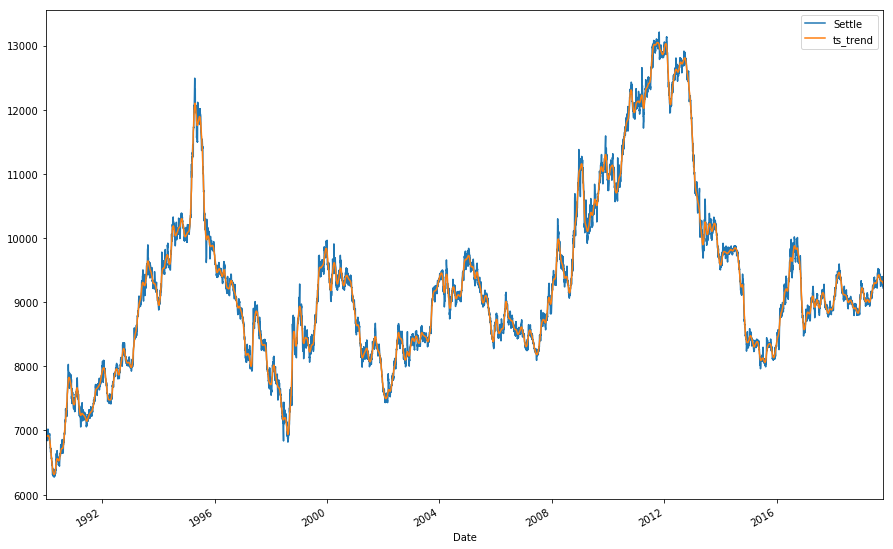

In [12]:
# Plot the Settle Price vs. the Trend for 2015 to the present
yen_futures[['Settle','ts_trend']].plot(figsize=(15,10))

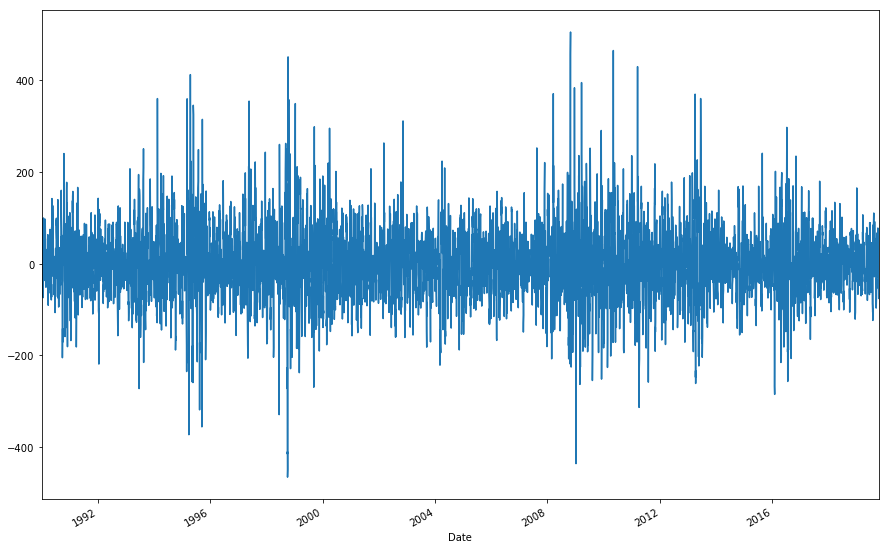

In [13]:
# Plot the Settle Noise
ts_noise.plot(figsize=(15,10))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [14]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [15]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

C:\Users\aduri\anaconda3\envs\pyvizenv2\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [17]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 18 Feb 2021   AIC                          15798.142
Time:                        15:46:50   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.197
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3352           +0.0000j            3.3352            0.5000
AR.2         -157.2096           +0.0000j          157.2096            0.5000
MA.1           -3.3941           +0.0000j            3.3941            0.5000
-----------------------------------------------------------------------------
"""

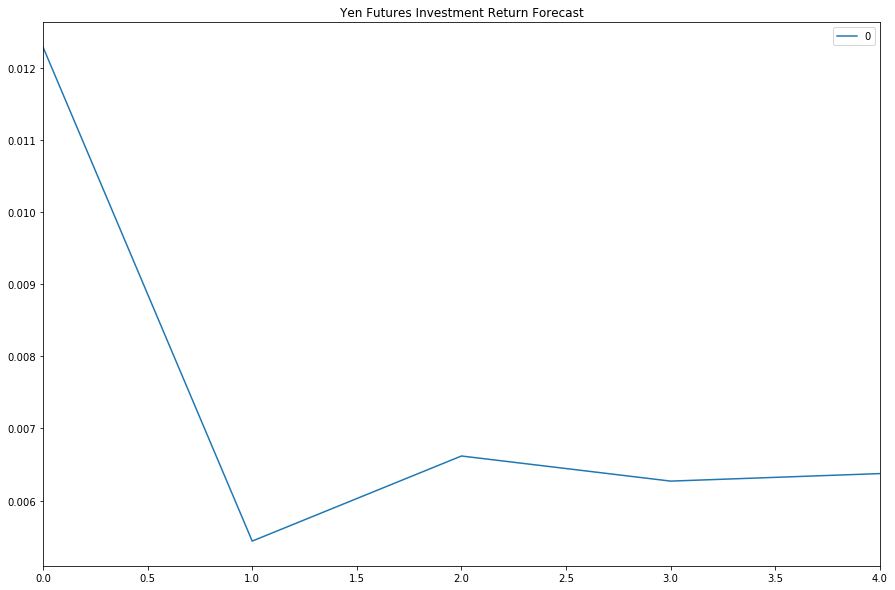

In [18]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Yen Futures Investment Return Forecast",figsize=(15,10))

In [138]:
returns.head()

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275


---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [20]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model_1 = ARIMA(returns['Settle'], order=(5, 1, 1))

# Fit the model
results_arima = model_1.fit()

C:\Users\aduri\anaconda3\envs\pyvizenv2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\aduri\anaconda3\envs\pyvizenv2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [21]:
# Output model summary results:
results_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7513
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7895.747
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 18 Feb 2021   AIC                          15807.495
Time:                        15:47:26   BIC                          15862.890
Sample:                             1   HQIC                         15826.515
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -3.208e-06   3.68e-06     -0.872      0.383   -1.04e-05       4e-06
ar.L1.D.Settle    -0.0131      0.012     -1.134      0.257      -0.036       0.010
ar.L2.D.Settle    -0.0022      0.012     -0.187      0.852      -0.025       0.020
ar.L3.D.Settle    -0.0126      0.012     -1.088      0.276      -0.035       0.010
ar.L4.D.Settle    -0.0209      0.012     -1.813      0.070      -0.044       0.002
ar.L5.D.Settle     0.0026      0.012      0.223      0.823      -0.020       0.025
ma.L1.D.Settle    -0.9999      0.000  -2266.734      0.000      -1.001      -0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.9408           -1.6433j            2.5430           -0.3882
AR.2           -1.9408           +1.6433j            2.5430            0.3882
AR.3            1.6205           -2.0555j            2.6175           -0.1438
AR.4            1.6205           +2.0555j            2.6175            0.1438
AR.5            8.7650           -0.0000j            8.7650           -0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

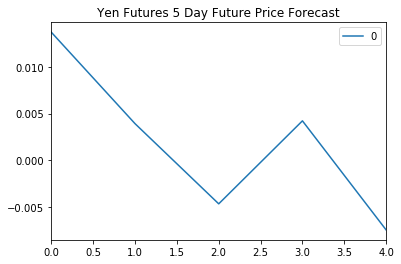

In [144]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(results_arima.forecast(steps=5)[0]).plot(title="Yen Futures 5 Day Future Price Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [25]:
import arch as arch

ModuleNotFoundError: No module named 'arch'

In [27]:
# Estimate a GARCH model:
from arch import arch_model
model = arch_model(returns, mean="Zero", vol="GARCH", p=5, q=1)
# Fit the model
results = model.fit(disp="off")

ModuleNotFoundError: No module named 'arch'

In [29]:
# Summarize the model results
results.summary()

NameError: name 'res' is not defined

In [30]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [33]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = results.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

TypeError: forecast() got an unexpected keyword argument 'start'

In [34]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

NameError: name 'forecasts' is not defined

In [35]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

NameError: name 'intermediate' is not defined

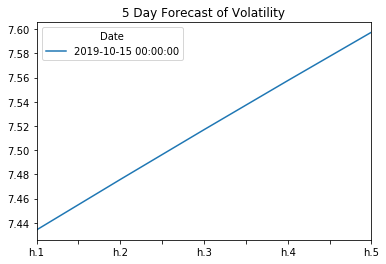

In [23]:
# Plot the final forecast
final.plot()

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

# We would not buy as the 5 days trend is downward
#Risk of Yen is increased
#Yes the model is reliable to forecast the returns